# Library

In [10]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum


In [11]:
class Config(Enum):
    seed = 100


In [12]:
rng = np.random.default_rng(Config.seed.value)


# Import data & Preprocess

In [13]:
class CalDataset:
    def __init__(self) -> None:
        feature = pd.read_csv("./exercise.csv")
        label = pd.read_csv("./calories.csv")

        feature = feature.drop("User_ID", axis=1)
        label = label.drop("User_ID", axis=1)

        feature["Gender"] = feature["Gender"].map({"male": 1, "female": 0})

        self.header = feature.columns

        self.data = pd.concat((feature, label), axis=1).to_numpy()

    def random_split(self):
        rng_data = rng.permutation(self.data)

        train_split = int(np.floor(0.7 * self.__len__()))
        validate_split = int(np.floor(0.8 * self.__len__()))

        return (
            rng_data[:train_split],
            rng_data[train_split:validate_split],
            rng_data[validate_split:],
        )

    def __getitem__(self, index: int):
        return self.data[index]

    def __len__(self):
        return len(self.data)

    def getHeader(self):
        return self.header


In [14]:
data = CalDataset()
train_data, validate_data, test_data = data.random_split()


In [15]:
def calMSE(predict: np.ndarray, actual: np.ndarray):
    return np.mean((predict - actual) ** 2)


def calCorr(header, data: np.ndarray):
    corr = np.corrcoef(data.T).T[-1][:-1]
    for head, corrcoef in zip(header, corr):
        print(f"{head : <10} {corrcoef}")


In [63]:
def getBasisMatrix(features: np.ndarray, n_centroids):
    def __getGaussianBasis(x: np.ndarray, mu: np.ndarray, s: np.ndarray):
        numerator = -((x - mu) ** 2)
        denominator = 2 * s**2

        return np.exp(numerator / denominator)

    def __getmu(s, x_min, n_centroid):
        mu = [x_min + s * (i + 1) for i in range(int(n_centroid))]
        return np.asarray(mu)

    n_centroids = np.array(n_centroids)
    n_row = features.shape[0]
    x_mins = np.min(features, axis=0)
    x_maxs = np.max(features, axis=0)

    ss = (x_maxs - x_mins) / (n_centroids - 1)

    mus = [
        __getmu(s, x_min, n_centroid)
        for s, x_min, n_centroid in zip(ss, x_mins, n_centroids - 1)
    ]

    phi_each = [np.ones((mu.shape[0], 1, n_row)) for mu in mus]

    for i, (x, s, mu) in enumerate(zip(features.T, ss, mus)):
        for j, mu_j in enumerate(mu):
            phi_each[i][j][0] = __getGaussianBasis(x, mu_j, s)

    matrix = np.ones((1, 1, n_row))

    for phi in phi_each:
        matrix = np.einsum("ijk,mjk->imk", matrix, phi)
        matrix = matrix.reshape((-1, 1, phi.shape[-1]))

    return matrix.reshape((n_row, -1))


def normalize(feature: np.ndarray):
    normcoef = norm(feature, axis=0)
    return (feature.T / normcoef[:, np.newaxis]).T


def chooseFeatures(data: np.ndarray, num_feature):
    corr = np.corrcoef(data.T).T[-1][:-1]
    return np.argpartition(corr, num_feature)[num_feature:]


In [26]:
def MLR(
    train_feature, train_label, test_feature, n_centroids=[2, 2, 2, 2, 2, 2, 2]
):
    x_basisMatrix = getBasisMatrix(train_feature, n_centroids)
    weight = (
        inv(x_basisMatrix.T @ x_basisMatrix) @ x_basisMatrix.T @ train_label
    )

    y_basisMatrix = getBasisMatrix(test_feature, n_centroids)
    return y_basisMatrix @ weight


In [61]:
np.asarray([2, 2, 2, 2, 2, 2, 2]) - 1


array([1, 1, 1, 1, 1, 1, 1])

In [64]:
train_x = train_data[:, :-1]
train_y = train_data[:, -1]
test_x = test_data[:, :-1]
test_y = test_data[:, -1]

y_pred = MLR(train_x, train_y, test_x)
print(calMSE(y_pred, test_y))


11907.051


/var/folders/2d/q4w5638n0tq6qp416b338_4r0000gn/T/ipykernel_70676/2088679939.py:17: RuntimeWarning: divide by zero encountered in divide
  ss = (x_maxs - x_mins) / (n_centroids - 1)


<Axes: xlabel='Duration', ylabel='Calories'>

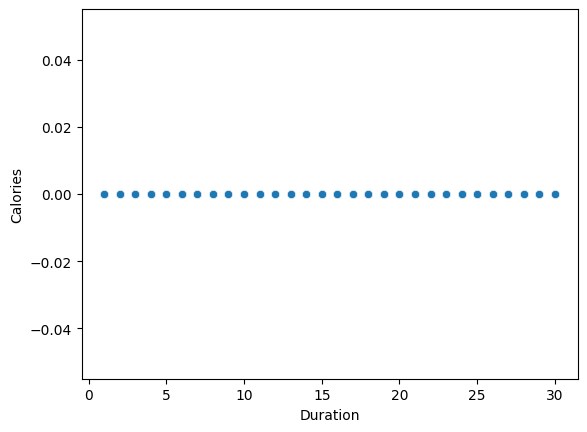

In [65]:
df = pd.DataFrame(test_data[:, 4], columns=["Duration"])
df["Calories"] = pd.DataFrame(y_pred)
sns.scatterplot(df, x="Duration", y="Calories")
